## 1. Import Required Packages

In [2]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import itertools
from collections import defaultdict
from collections import OrderedDict
from operator import itemgetter

---

### Notebook: DataCleaning-FeatureSelection-DataExploration_Facility-ID_3010 contains the all steps for cleaning dataset and exploratory data analysis.
This is done to keep notebook to a manageable length.

---

## 6. Sequential Patten Mining: Prefix-Span Algorithm


Sequential pattern mining is to find sub sequences for given a set of sequences and support threshold.

**Key terms:**

**_data-sequences:_**
    It is the input data and is a list of transactions.
    
**_transactions:_** 
    a set of literals, called items.
    
**_sequential-pattern:_** 
    list of set of items indicating a specific pattern of items.
    
**_minimum-support:_** 
    percentage of data-sequences that contains the pattern.

### 6.1 Transform Dataset in Sequences for  Sequential Patten Mining:

1. Remove alarms from dataset, which has one-to-one relation.
2. All alarm records between two consecutive severity 3 alarm is considered as a data-sequence
3. Alarms occurring at a particular time is considered as a transaction
4. Each unique alarm is considered as an item.


Ex: Sequential Data for alarm 1204 with severity 3 for which we want to sub-sequence which can be result in prediction of alarm 1204:

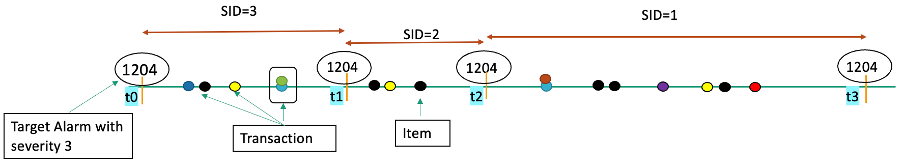

In [19]:
def createDataset(sub_df, target):
    
    '''
    This Function creates the sequential dataset from the given dataframe for target alarm
        Input:  df:pandasDataFrame
                anchor: int
                alarmlist: list
                combo: int
        Output: dict 
    '''
    
    # Get instances when target (alarm with severity 3) occurs
    inst = list(sub_df.loc[sub_df['Alarm'] == target]['AlarmTime'])
    
    sub_df = sub_df.loc[sub_df['AlarmTime'] < inst[-1]]
    sub_df.reset_index(drop=True)

    # Create transaction in data sequence
    sub_df = sub_df.groupby(['AlarmTime'])['Alarm'].apply(lambda x: [num for num in x])
    
    # Reverse the dataframe for easy iteration
    sub_df = sub_df[::-1]
 
    main = []
    sub = [[target]]
    
    # Create data sequence
    for e in sub_df:
        if e != [target]:
            sub.append(e)
        else:
            main.append(sub)
            sub = [[target]]
    main.append(sub)
    
    return main

In [20]:
def createMasterDataset(df, target, alarm_list, combo):
    
    '''
    This Function creates the sequential dataset from the given dataframe for target alarm
    for all possible combinations of alarms.
        Input:  df:pandasDataFrame
                anchor: int
                alarmlist: list
                combo: int
        Output: dict
    
    '''
    
    
    all_seq = {}
    
    # Remove target alarm from the list
    alarm_list.remove(target)
    
    
    # Create possible combinations of alarms
    pairs = itertools.combinations(alarm_list, combo)

    for p in pairs:
        alarms_to_keep = [target] + list(p)

        # Keep traget and pairs alarms
        tmp = df[df['Alarm'].isin(alarms_to_keep)]

        # Create dictonary for all sequences
        all_seq[tuple(alarms_to_keep)] = createDataset(tmp, target)

    return all_seq

### 6.2  Prefix-Span Sequential Pattern Mining Algorithm:

In [21]:
def projectSequence(sequence, prefix, newEvent):
    
    '''
    This function projects a sequence according to a given prefix, as per the PrefixSpan algorithm.
        Input:
            sequence: the sequence the projection is built from
            prefix: the prefix that is searched for in the sequence
            newEvent: if set to True, the first itemset is ignored
        Output:
            If the sequence does not contain the prefix, then None.
        Otherwise, a new sequence starting from the position of the prefix, including the itemset 
        that includes the prefix
    '''
    
    result = None
    for i, itemset in enumerate(sequence):
        if result is None:
            if (not newEvent) or i > 0:
                if (all(x in itemset for x in prefix)):
                    result = [list(itemset)]
        else:
            result.append(copy.copy(itemset))
    return result

In [22]:
def projectDatabase(dataset, prefix, newEvent):

    '''
    This function projects whole dataset according to a given prefix, as per the PrefixSpan algorithm.
        Input:
            dataset: the dataset the projection is built from
            prefix: the prefix that is searched for in the sequence
            newEvent: if set to True, the first itemset is ignored
        Output:
            A (potentially empty) list of sequences
    '''
    
    projectedDB = []
    for sequence in dataset:
        
        # Project data sequence for given prefix 
        seqProjected = projectSequence(sequence, prefix, newEvent)
        if not seqProjected is None:
            projectedDB.append(seqProjected)
    return projectedDB

In [23]:
def generateItems(dataset):
    
    '''
    This function generates a list of all unique items that are contained in a dataset
        Input:
            dataset: the dataset (list of list)
        Output:
            A set of items
    '''
    
    return sorted(set ([item for sublist1 in dataset for sublist2 in sublist1 for item in sublist2]))

In [24]:
def generateItemSupports(dataset, ignoreFirstEvent=False, prefix=[]):
    
    '''
    This function computes a defaultdict that maps each item in the dataset to its support in the dataset.
        Input:
            dataset: the dataset (list of list)
        Output:
            support for each sub sequence/Item
    '''
    
    result = defaultdict(int)
    for sequence in dataset:
        if ignoreFirstEvent:
            sequence = sequence[1:]
        cooccurringItems = set()
        for itemset in sequence:
            if all(x in itemset for x in prefix):
                for item in itemset:
                    if not item in prefix:
                        cooccurringItems.add(item)
        for item in cooccurringItems:
            result [item] += 1
    return sorted(result.items())

In [25]:
def prefixSpan(dataset, minSupport):
    
    '''
    This function computes the frequent sequences in a seqeunce dataset for a given minSupport.
        Input:
            dataset: A list of sequences, for which the frequent (sub-)sequences are computed
            minSupport: The minimum support that makes a sequence frequent
        Output:
            A list of tuples (s, c), where s is a frequent sequence, and c is the count for that sequence
    '''
    
    result = []
    itemCounts = generateItemSupports(dataset)
    for item, count in itemCounts:
        if count >= minSupport:
            newPrefix = [[item]]
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, [item], False), minSupport, newPrefix))
    return result



def prefixSpanInternal(dataset, minSupport, prevPrefixes=[]):
    
    result = []
    
    # Add a new item to the last element (==same time)
    itemCountSameEvent = generateItemSupports(dataset, False, prefix=prevPrefixes[-1])
    for item, count in itemCountSameEvent:
        if (count >= minSupport) and item > prevPrefixes[-1][-1]:
            newPrefix = copy.deepcopy(prevPrefixes)
            newPrefix[-1].append(item)
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, newPrefix[-1], False), minSupport, newPrefix))
        
    # Add a new event to the prefix
    itemCountSubsequentEvents = generateItemSupports(dataset, True)
    for item, count in itemCountSubsequentEvents:
        if count >= minSupport:
            newPrefix = copy.deepcopy(prevPrefixes)
            newPrefix.append([item])
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, [item], True), minSupport, newPrefix))
    return result

In [26]:
def getMinLengthSupportSubSeq(df, sequence, target, min_support, min_length):
    
    '''
    This function peforms the prefix-span algorithm and return sub seqences with given minimum length.
      Input:
        df: pandas dataframe
        seqence : sequential dataset: list
        target: target alarm: int
        min_support: The minimum threshold that makes a sequence frequent
        min_length: The minimum length of the sub-sequence
      Output:
        Pandas Dataframe which contains sub-sequences with their min support
    '''

    support_dict = {}
    
    tmp_seq_dict = copy.deepcopy(sequence)
    
    target_count = list(df.loc[df['Alarm']==target]['Alarm'].value_counts())[0]
    min_support = (target_count * min_support)//100
    
    for key in tmp_seq_dict.keys():

        # Perform prefix-span algorithm
        tmp_seq_dict[key] = prefixSpan(tmp_seq_dict[key], min_support)
        
        # Filter out the sub-sequences, which has length greater than minimum length
        for result in tmp_seq_dict[key]:
            if (len(result[0]) >= min_length) & (result[0][0] == [target]):
                l = []
                for r in result[0]:
                    l += r
                
                if len(set(l)) != 1:
                    try: 
                        support_dict[key].append(result)   
                    except:
                        support_dict[key] = [result]
    
    for key in support_dict.keys():
        support_dict[key] = list(support_dict[key])
    
    #df = pd.DataFrame.from_dict(support_dict, orient='index')
  
    if support_dict:
        num = target_count/100
        out_seq = {}

        for val in support_dict.values():
            for v in val:
                try:
                    if out_seq[str(v[0])] < v[1]:
                        out_seq[str(v[0])] = v[1]
                except:
                    out_seq[str(v[0])] = v[1]

        df_tmp = pd.DataFrame.from_dict(out_seq, orient='index')
        df_tmp = df_tmp.reset_index(level=0)
        df_tmp = df_tmp.rename(columns={'index': 'sequences', 0:'per_support'})
        df_tmp['per_support'] = df_tmp['per_support']/num
        df_tmp = df_tmp.sort_values(by=['per_support'], ascending=False)

        return df_tmp
    
    else:
        return "No sub-sequence with minimum support found"

In [27]:
def plotSupportPerc(df):
    
    '''
    This function plot bar chart for given dataframe.
      Input:
        df: pandas dataframe
    '''
    
    # Define figure size
    plt.figure(figsize=(10,5))

    sns.barplot(x=df['per_support'],y=df['sequences'], data=df, palette="husl")
    
    plt.xlim(0,100)
    plt.show()

### 6.3 Results:

Here we are running our algorithm for alarm 1203, 1036, 1400, 1402, 1204, and 1047. for 1205, 1206 and 1029 has very less number of records compared to dataset size.


### Sub-Sequences for Alarm 1203:

In [25]:
# Get alarm list
alarms = list(system_alarms['Alarm'].unique())

# Get alarms list with severity 3
# Note: We are creating sequence for 1203 
alarm_sev_3 = 1203

# Here, we create combinations of max 3 alarms
# We can increase the no of alarms in one combination
# However due to limited computational resources, we create combinations of max 3 alarms
combinations = 3

# Create data sequence for traget alarms with severity 3                                              
alarm_seqs_1203 = createMasterDataset(system_alarms, alarm_sev_3, alarms, combinations) 

In [36]:
df_subSeq_fre_1203 = getMinLeng thSupportSubSeq(system_alarms, alarm_seqs_1203, 1203, 50, 2)
df_subSeq_fre_1203

,sequences,per_support
3,"[[1203], [1037]]",84.262526
7,"[[1203], [1003]]",81.227946
14,"[[1203], [1037], [1003]]",75.299929
5,"[[1203], [1037], [1037]]",68.313338
11,"[[1203], [1003], [1037]]",64.714185
16,"[[1203], [1037], [1003], [1037]]",61.891320
8,"[[1203], [1003], [1003]]",60.338744
0,"[[1203], [1013]]",59.915314
10,"[[1203], [1046]]",59.209598
19,"[[1203], [1037], [1037], [1003]]",58.997883


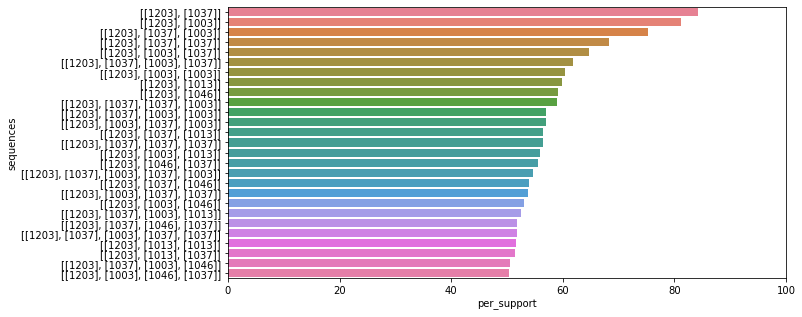

In [37]:
plotSupportPerc(df_subSeq_fre_1203.loc[df_subSeq_fre_1203['per_support']>=50.00])

### Sub-Sequences for Alarm 1402:

In [38]:
# Get alarm list
alarms = list(system_alarms['Alarm'].unique())

# Get alarms list with severity 3
# Note: We are creating sequence for 1402
alarm_sev_3 = 1402

# Here, we create combinations of max 3 alarms
# We can increase the no of alarms in one combination
# However due to limited computational resources, we create combinations of max 3 alarms
combinations = 3

# Create data sequence for traget alarms with severity 3                                              
alarm_seqs_1402 = createMasterDataset(system_alarms, alarm_sev_3, alarms, combinations) 

In [42]:
df_subSeq_fre_1402 = getMinLengthSupportSubSeq(system_alarms, alarm_seqs_1402, 1402, 50, 2)
df_subSeq_fre_1402

'No sub-sequence with minimum support found'

### Sub-Sequences for Alarm 1400:

In [43]:
# Get alarm list
alarms = list(system_alarms['Alarm'].unique())

# Get alarms list with severity 3
# Note: We are creating sequence for 1400 
alarm_sev_3 = 1400

# Here, we create combinations of max 3 alarms
# We can increase the no of alarms in one combination
# However due to limited computational resources, we create combinations of max 3 alarms
combinations = 3

# Create data sequence for traget alarms with severity 3                                              
alarm_seqs_1400 = createMasterDataset(system_alarms, alarm_sev_3, alarms, combinations) 

In [44]:
df_subSeq_fre_1400 = getMinLengthSupportSubSeq(system_alarms, alarm_seqs_1400, 1400, 50, 2)
df_subSeq_fre_1400

'No sub-sequence with minimum support found'

### Sub-Sequences for Alarm 1204:

In [64]:
# Get alarm list
alarms = list(system_alarms['Alarm'].unique())

# Get alarms list with severity 3
# Note: We are creating sequence for 1204 
alarm_sev_3 = 1204

# Here, we create combinations of max 3 alarms
# We can increase the no of alarms in one combination
# However due to limited computational resources, we create combinations of max 3 alarms
combinations = 3

# Create data sequence for traget alarms with severity 3                                              
alarm_seqs_1204 = createMasterDataset(system_alarms, alarm_sev_3, alarms, combinations) 

In [65]:
df_subSeq_fre_1204 = getMinLengthSupportSubSeq(system_alarms, alarm_seqs_1204, 1204, 70, 2)
df_subSeq_fre_1204

,sequences,per_support
1,"[[1204], [1004]]",100.0
3,"[[1204], [1037]]",100.0
5,"[[1204], [1037], [1004]]",100.0
0,"[[1204], [1013]]",70.0
2,"[[1204], [1004], [1013]]",70.0
4,"[[1204], [1037], [1013]]",70.0
6,"[[1204], [1037], [1004], [1013]]",70.0


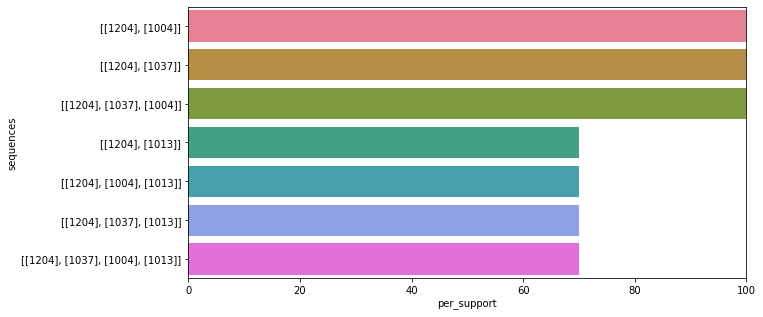

In [66]:
plotSupportPerc(df_subSeq_fre_1204.loc[df_subSeq_fre_1204['per_support']>=70.00])

### Sub-Sequences for Alarm 1036:

In [51]:
# Get alarm list
alarms = list(system_alarms['Alarm'].unique())

# Get alarms list with severity 3
# Note: We are creating sequence for 1036 
alarm_sev_3 = 1036

# Here, we create combinations of max 3 alarms
# We can increase the no of alarms in one combination
# However due to limited computational resources, we create combinations of max 3 alarms
combinations = 3

# Create data sequence for traget alarms with severity 3                                              
alarm_seqs_1036 = createMasterDataset(system_alarms, alarm_sev_3, alarms, combinations) 

In [52]:
df_subSeq_fre_1036 = getMinLengthSupportSubSeq(system_alarms, alarm_seqs_1036, 1036, 50, 2)
df_subSeq_fre_1036

'No sub-sequence with minimum support found'

### Sub-Sequences for Alarm 1047:

In [67]:
# Get alarm list
alarms = list(system_alarms['Alarm'].unique())

# Get alarms list with severity 3
# Note: We are creating sequence for 1036 
alarm_sev_3 = 1047

# Here, we create combinations of max 3 alarms
# We can increase the no of alarms in one combination
# However due to limited computational resources, we create combinations of max 3 alarms
combinations = 3

# Create data sequence for traget alarms with severity 3                                              
alarm_seqs_1047 = createMasterDataset(system_alarms, alarm_sev_3, alarms, combinations) 

In [ ]:
df_subSeq_fre_1047 = getMinLengthSupportSubSeq(system_alarms, alarm_seqs_1047, 1047, 50, 2)

In [ ]:
plotSupportPerc(df_subSeq_fre_1047.loc[df_subSeq_fre_1047['per_support']>=50.00])

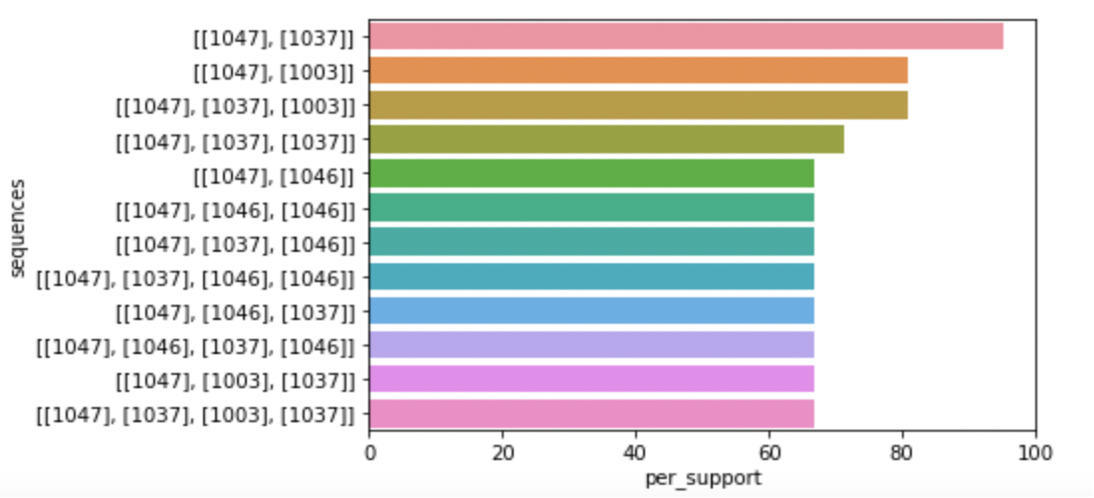

Now check how much time we have to predict severity 3 alarm.

Here we are finding time difference only for top most frequent sub-sequences. We can follow the same for remaining. 

    1. [[1203],[1037]]
    2. [[1203],[1003]]
    3. [[1203],[1003], [1037]]
    4. [[1203],[1037], [1003]]

    5. [[1204],[1004]]
    6. [[1204],[1037]]
    7. [[1204],[1037], [1004]]
    8. [[1204],[1013]]
    9. [[1204],[1004],[1013]]
    10.[[1204],[1037],[1013]]
   
    11. [[1047],[1037]]
    12. [[1047],[1003]]
    13. [[1047],[1037],[1003]]
    14. [[1047],[1046]]

In [58]:
def timeDifference(df, alarms_list):
    

    '''
    This function returns the mean and median of time difference between alarms and
    also count of the occurences of alarm

    '''
    if len(alarms_list) == 2:
        
        df = df[df['Alarm'].isin(alarms_list)][['Alarm', 'AlarmTime']]

        df['deltaT'] = df.AlarmTime.diff().astype('timedelta64[s]').fillna(0).astype('int')

        count = 0
        time_delta = 0
        comb = []

        for _, row in df.iterrows():

            if row['Alarm'] == alarms_list[1]:
                time_delta += row['deltaT']
                count += 1
            else:
                time_delta += row['deltaT']
                comb.append((row['AlarmTime'], count, time_delta//60))

                count = 0
                time_delta = 0

        timeDelT_df = pd.DataFrame(comb, columns =['AlarmTime', 'Occurance', 'TimeDelta_min'])

        return timeDelT_df.describe(percentiles=[.50]).loc[['mean','50%']]


    else:

        df = df[df['Alarm'].isin(alarms_list)][['Alarm', 'AlarmTime']]

        count = 0
        comb = []

        for index, row in df.iterrows():

            if row['Alarm'] != alarms_list[0]:

                if (row['Alarm'] == alarms_list[1]) & (index < df.shape[0]-1):
                    if (df.iloc[index+1]['Alarm']==alarms_list[2]):
                        count += 1
                    if count == 1:
                        start = row['AlarmTime']
            else:
                if count != 0: 
                    time_delta = row['AlarmTime'] - start 
                    time_delta_min = (time_delta/np.timedelta64(1,'s'))//60
                    comb.append((row['AlarmTime'], count, int(time_delta_min)))

                    count = 0

        timeDelT_df = pd.DataFrame(comb, columns =['AlarmTime', 'Occurrence', 'TimeDelta_min'])

        return timeDelT_df.describe(percentiles=[.50]).loc[['mean','50%']]

In [59]:
timeDifference(system_alarms, [1203,1037])

,Occurance,TimeDelta_min
mean,11.731122,83.056457
50%,3.000000,5.000000


In [60]:
timeDifference(system_alarms, [1203,1003])

,Occurance,TimeDelta_min
mean,9.448836,83.056457
50%,2.000000,5.000000


In [61]:
timeDifference(system_alarms, [1203,1037,1003])

,Occurrence,TimeDelta_min
mean,8.132231,98.743802
50%,2.000000,4.000000


In [62]:
timeDifference(system_alarms, [1203,1003,1037])

,Occurrence,TimeDelta_min
mean,9.713115,99.303279
50%,3.000000,8.500000


In [70]:
timeDifference(system_alarms, [1204,1004])

,Occurance,TimeDelta_min
mean,14.09127,468.289683
50%,3.00000,30.000000


In [71]:
timeDifference(system_alarms, [1204,1037])

,Occurance,TimeDelta_min
mean,65.960317,468.289683
50%,8.000000,30.000000


In [72]:
timeDifference(system_alarms, [1204,1037,1004])

,Occurrence,TimeDelta_min
mean,23.166667,2011.166667
50%,10.000000,1801.000000


In [73]:
timeDifference(system_alarms, [1204,1013])

,Occurance,TimeDelta_min
mean,438.27381,468.325397
50%,22.50000,30.000000


In [74]:
timeDifference(system_alarms, [1204,1004,1013])

,Occurrence,TimeDelta_min
mean,13.1,296.129412
50%,4.0,10.000000


In [75]:
timeDifference(system_alarms, [1204,1037,1013])

,Occurrence,TimeDelta_min
mean,67.617143,421.965714
50%,8.000000,22.000000


In [76]:
timeDifference(system_alarms, [1204,1037,1004])

,Occurrence,TimeDelta_min
mean,23.166667,2011.166667
50%,10.000000,1801.000000


In [77]:
timeDifference(system_alarms, [1047,1037])

,Occurance,TimeDelta_min
mean,90.666667,640.901639
50%,26.000000,41.000000


In [78]:
timeDifference(system_alarms, [1047,1003])

,Occurance,TimeDelta_min
mean,73.092896,640.901639
50%,21.000000,41.000000


In [79]:
timeDifference(system_alarms, [1047,1037,1003])

,Occurrence,TimeDelta_min
mean,64.8,972.733333
50%,22.0,165.000000


In [80]:
timeDifference(system_alarms, [1047,1046])

,Occurance,TimeDelta_min
mean,69.721311,640.901639
50%,17.000000,41.000000


---